In [3]:
!pip3 install influxdb-client
!pip3 install tensorflow
!pip3 install pandas
!pip3 install numpy
!pip3 install sklearn
!pip3 install matplotlib
!pip3 install seaborn
!pip3 install keras
# brew install libomp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 744.1/744.1 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.8/217.8 kB 9.1 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [4]:
!pip3 install scalecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 72.8 MB/s eta 0:00:00
  Created wheel for scalecast: filename=SCALECAST-0.19.8-py3-none-any.whl size=125274 sha256=d7a54006efbc17763bbfa3e7c9f590f1265acd84ff8cd14c5a1ea4ff7f808f4f
  Stored in directory: /root/.cache/pip/wheels/ac/67/2e/0244bcec7f41d76aae4c4196b64d31a20d474a7d5468f3d67e
Successfully built scalecast
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import keras
from influxdb_client import InfluxDBClient, Point, WriteOptions
from influxdb_client.client.warnings import MissingPivotFunction
from sklearn.model_selection import train_test_split
from scalecast.Forecaster import Forecaster
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import time
import warnings
sns.set(rc={'figure.figsize':(25,8)})

In [137]:
# Reading data from DB

# InfluxDB credentials and details
url = "http://kammeyer.uk:8086"
token = "9V1NYZbTXZkbf9H0Szf8Gl-dOaqrl97TmdC9gwNhxkRCgAcHR7jGSxnPtwHq2vBL-UOd607yPlROxlJAhRAwqw=="
org = "messme"

# Initialize InfluxDB Client
client = InfluxDBClient(url=url, token=token, org=org)

# Define the query for the 'energy' bucket
query = """
from(bucket: "energy")
  |> range(start: -2y, stop: -3d )
  |> filter(fn: (r) => r._measurement == "energy_production")
  |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
"""


# Fetch data into a DataFrame
start = time.time()
df = client.query_api().query_data_frame(query=query)
end = time.time()
print("Time taken to read the data is : ", end-start)
df.tail()

Time taken to read the data is :  23.97512149810791


,result,table,_start,_stop,_time,_measurement,region,Biomasse,Braunkohle,Erdgas,Kernenergie,Photovoltaik,Pumpspeicher,Sonstige Erneuerbare,Sonstige Konventionelle,Steinkohle,Wasserkraft,Wind Offshore,Wind Onshore
69803,_result,0,2022-02-04 14:53:35.933866+00:00,2024-02-02 02:53:35.933866+00:00,2024-01-31 11:45:00+00:00,energy_production,DE,NaN,NaN,NaN,NaN,2157.5,NaN,NaN,NaN,NaN,NaN,1447.50,3939.5
69804,_result,0,2022-02-04 14:53:35.933866+00:00,2024-02-02 02:53:35.933866+00:00,2024-02-01 23:45:00+00:00,energy_production,DE,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1369.25,5182.5
69805,_result,0,2022-02-04 14:53:35.933866+00:00,2024-02-02 02:53:35.933866+00:00,2023-08-01 13:30:00+00:00,energy_production,DE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,844.75,NaN
69806,_result,0,2022-02-04 14:53:35.933866+00:00,2024-02-02 02:53:35.933866+00:00,2023-08-01 13:45:00+00:00,energy_production,DE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,859.25,NaN
69807,_result,0,2022-02-04 14:53:35.933866+00:00,2024-02-02 02:53:35.933866+00:00,2024-01-18 22:15:00+00:00,energy_production,DE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1208.75,NaN


In [138]:
# drop extra columns
columns_to_drop = ['result', '_start', '_stop', '_measurement', 'region']
df = df.drop(columns=columns_to_drop, inplace=False)

In [139]:
# Set index
df['_time'] = pd.to_datetime(df['_time'])
df = df.set_index('_time')

In [140]:
# Sort the DataFrame by index
df = df.sort_index()

In [141]:
df.tail(100)

,table,Biomasse,Braunkohle,Erdgas,Kernenergie,Photovoltaik,Pumpspeicher,Sonstige Erneuerbare,Sonstige Konventionelle,Steinkohle,Wasserkraft,Wind Offshore,Wind Onshore
_time,,,,,,,,,,,,,
2024-02-01 02:00:00+00:00,0,1340.50,1206.75,1197.25,NaN,0.0,4.00,28.25,329.50,1222.25,484.50,974.75,8655.75
2024-02-01 02:15:00+00:00,0,1342.50,1199.50,1174.25,NaN,0.0,4.25,28.50,330.50,1226.75,493.25,986.50,8586.00
2024-02-01 02:30:00+00:00,0,1342.75,1202.25,1170.50,NaN,0.0,0.00,28.50,333.00,1226.75,491.75,989.50,8531.00
2024-02-01 02:45:00+00:00,0,1336.50,1197.00,1181.00,NaN,0.0,0.25,28.75,327.75,1226.50,492.25,1003.50,8516.75
2024-02-01 03:00:00+00:00,0,1334.25,1204.50,1214.00,NaN,0.0,2.75,31.00,332.75,1241.25,492.75,1088.00,8384.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-02 01:45:00+00:00,0,1336.00,1326.25,1394.00,NaN,0.0,17.75,38.00,347.75,807.00,539.00,1561.75,4837.75
2024-02-02 02:00:00+00:00,0,1334.25,1344.25,1416.25,NaN,0.0,18.25,36.50,342.50,765.00,531.00,1552.00,4842.00
2024-02-02 02:15:00+00:00,0,1335.25,1330.50,1444.25,NaN,0.0,14.75,36.50,340.75,756.25,522.00,1535.25,4881.25


In [142]:
# Get data only for one energy source at a time
df_Braunkohle = df[["Braunkohle"]]

In [143]:
# Check if any further NaN is present and perform forward fill for those
nan_count = df_Braunkohle['Braunkohle'].isna().sum()
print("Number of NaN values in 'Braunkohle' column:", nan_count)

if nan_count > 0:
    df_Braunkohle['Braunkohle'] = df_Braunkohle['Braunkohle'].interpolate()
    print("Forward filled NaN values")

print("df_Braunkohle shape is:", df_Braunkohle.shape)

Number of NaN values in 'Braunkohle' column: 199
Forward filled NaN values
df_Braunkohle shape is: (69808, 1)


<ipython-input-143-c72fad46078d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Braunkohle['Braunkohle'] = df_Braunkohle['Braunkohle'].interpolate()


In [144]:
df_Braunkohle.tail()

,Braunkohle
_time,
2024-02-02 01:45:00+00:00,1326.25
2024-02-02 02:00:00+00:00,1344.25
2024-02-02 02:15:00+00:00,1330.50
2024-02-02 02:30:00+00:00,1328.50
2024-02-02 02:45:00+00:00,1326.50


In [145]:
nan_count = df_Braunkohle['Braunkohle'].isna().sum()

if nan_count > 0:
  print("We still have NaN values : ", nan_count)
  df_Braunkohle['Braunkohle'] = df_Braunkohle['Braunkohle'].ffill().bfill()

print(df_Braunkohle[df_Braunkohle['Braunkohle'].isna()])

Empty DataFrame
Columns: [Braunkohle]
Index: []


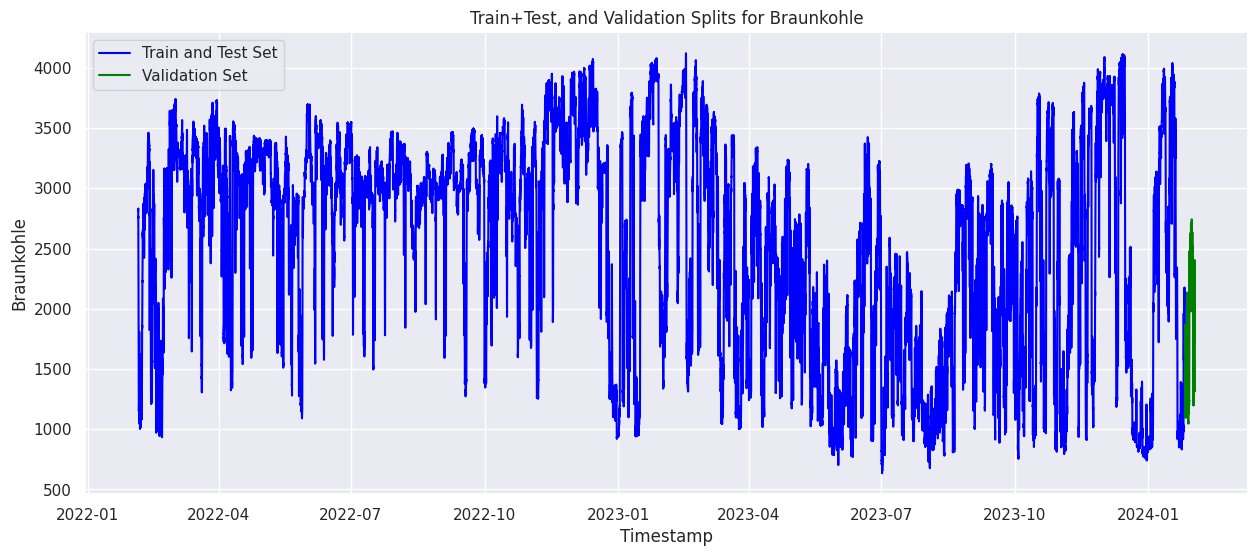

In [146]:
# Train, Test and Validation Splits
train_test_data = df_Braunkohle[:-672].copy()

# Split data into train, test, and validation sets
validation_data = df_Braunkohle[-672:]

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(train_test_data.index, train_test_data['Braunkohle'], label='Train and Test Set', color='blue')
plt.plot(validation_data.index, validation_data['Braunkohle'], label='Validation Set', color='green')

plt.title('Train+Test, and Validation Splits for Braunkohle')
plt.xlabel('Timestamp')
plt.ylabel('Braunkohle')
plt.legend()
plt.show()

In [147]:
f = Forecaster(y=train_test_data["Braunkohle"],current_dates=train_test_data.index, freq='15min')

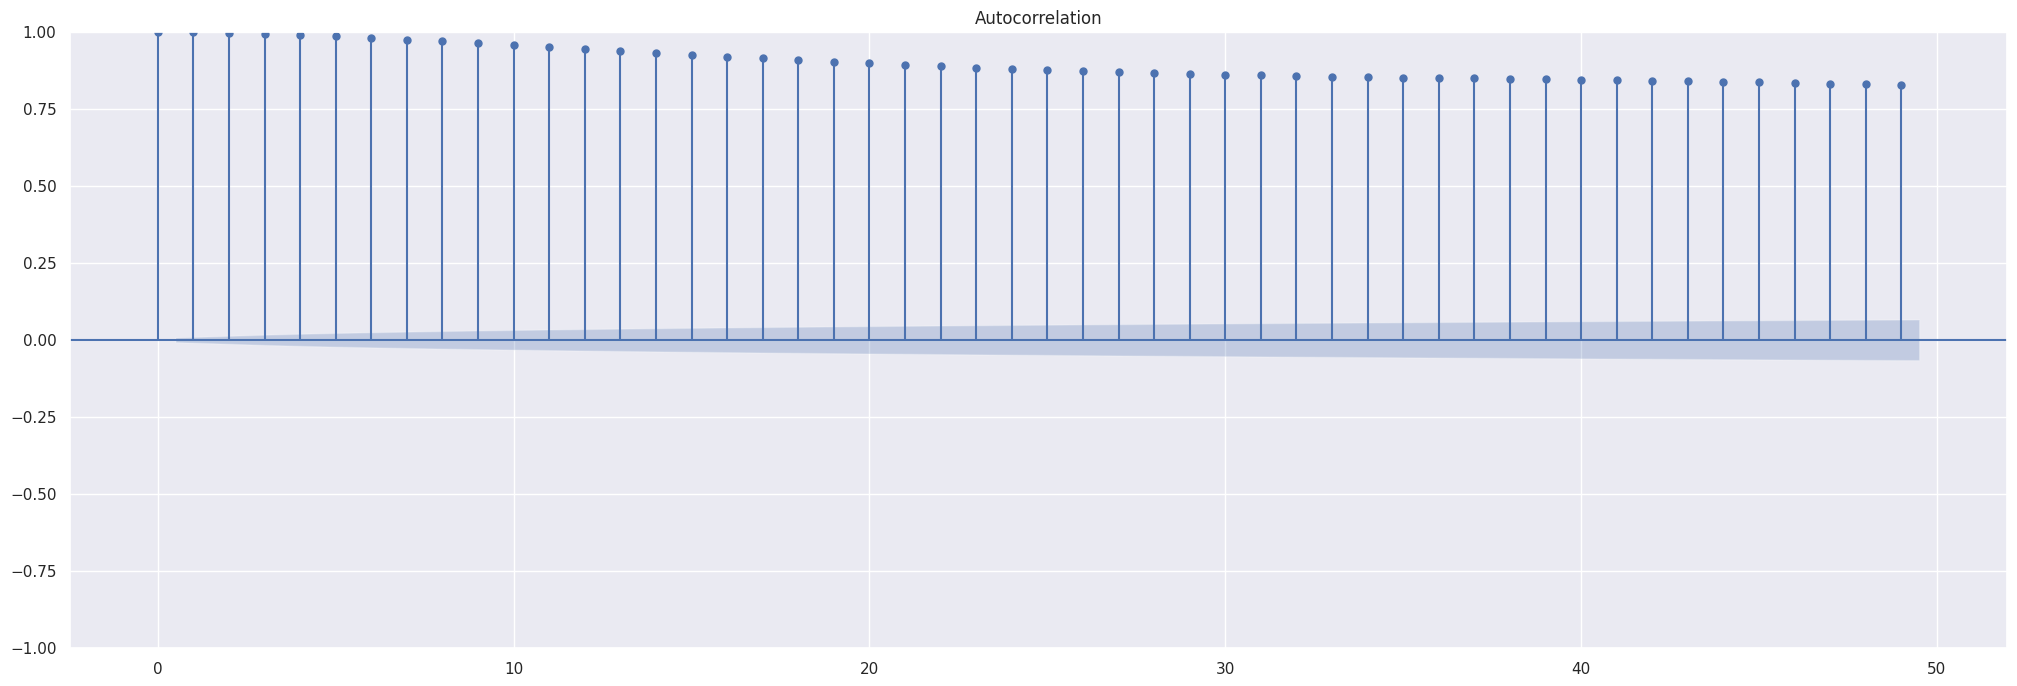

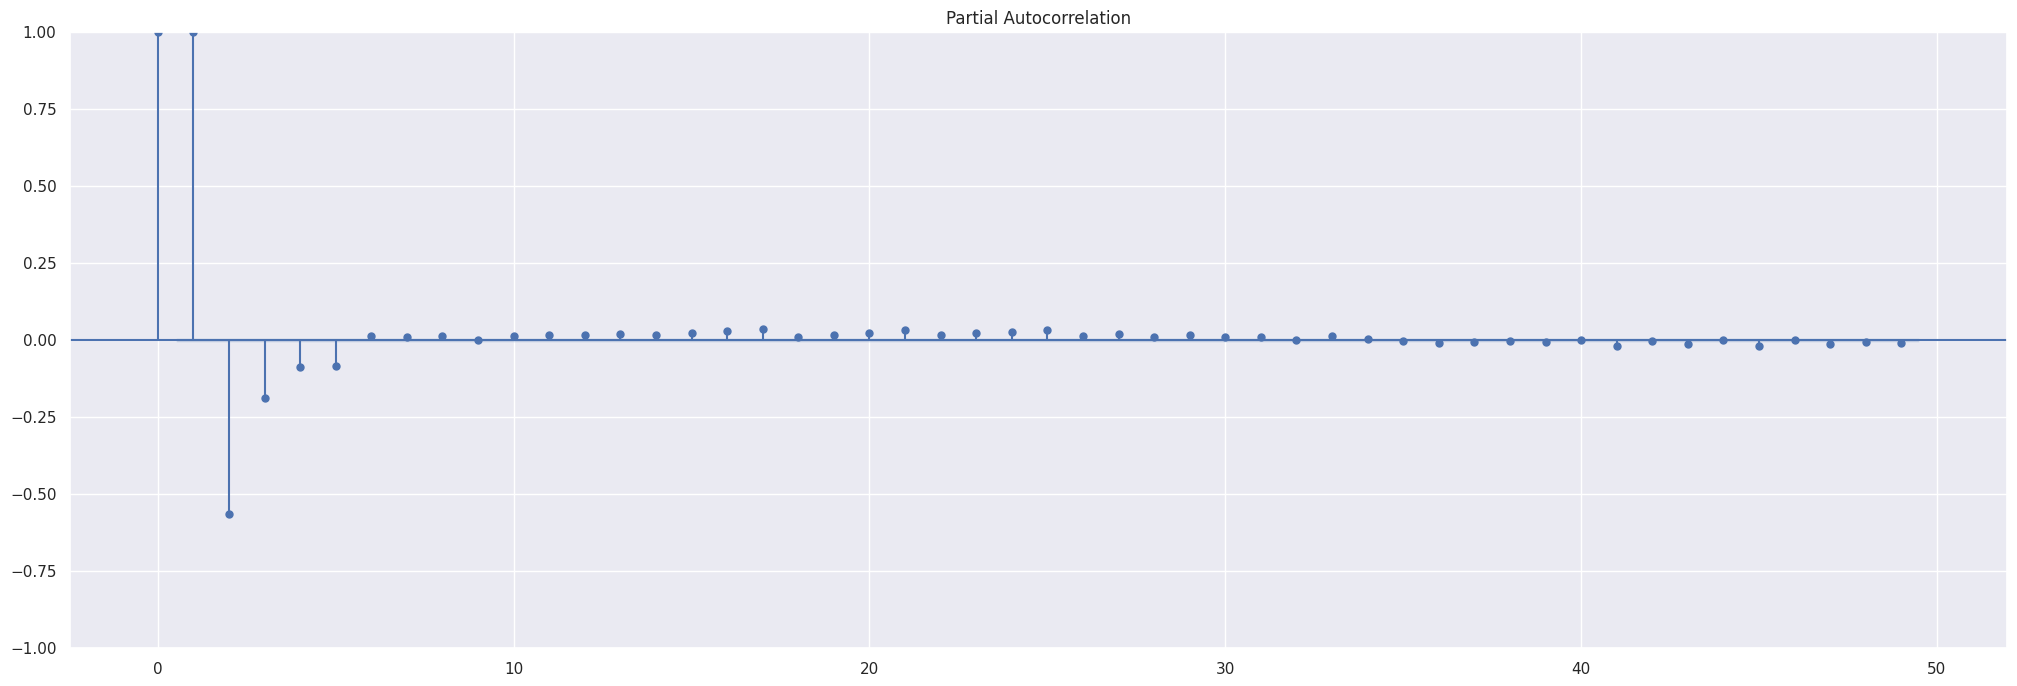

In [148]:
f.plot_acf()
f.plot_pacf()
plt.show()

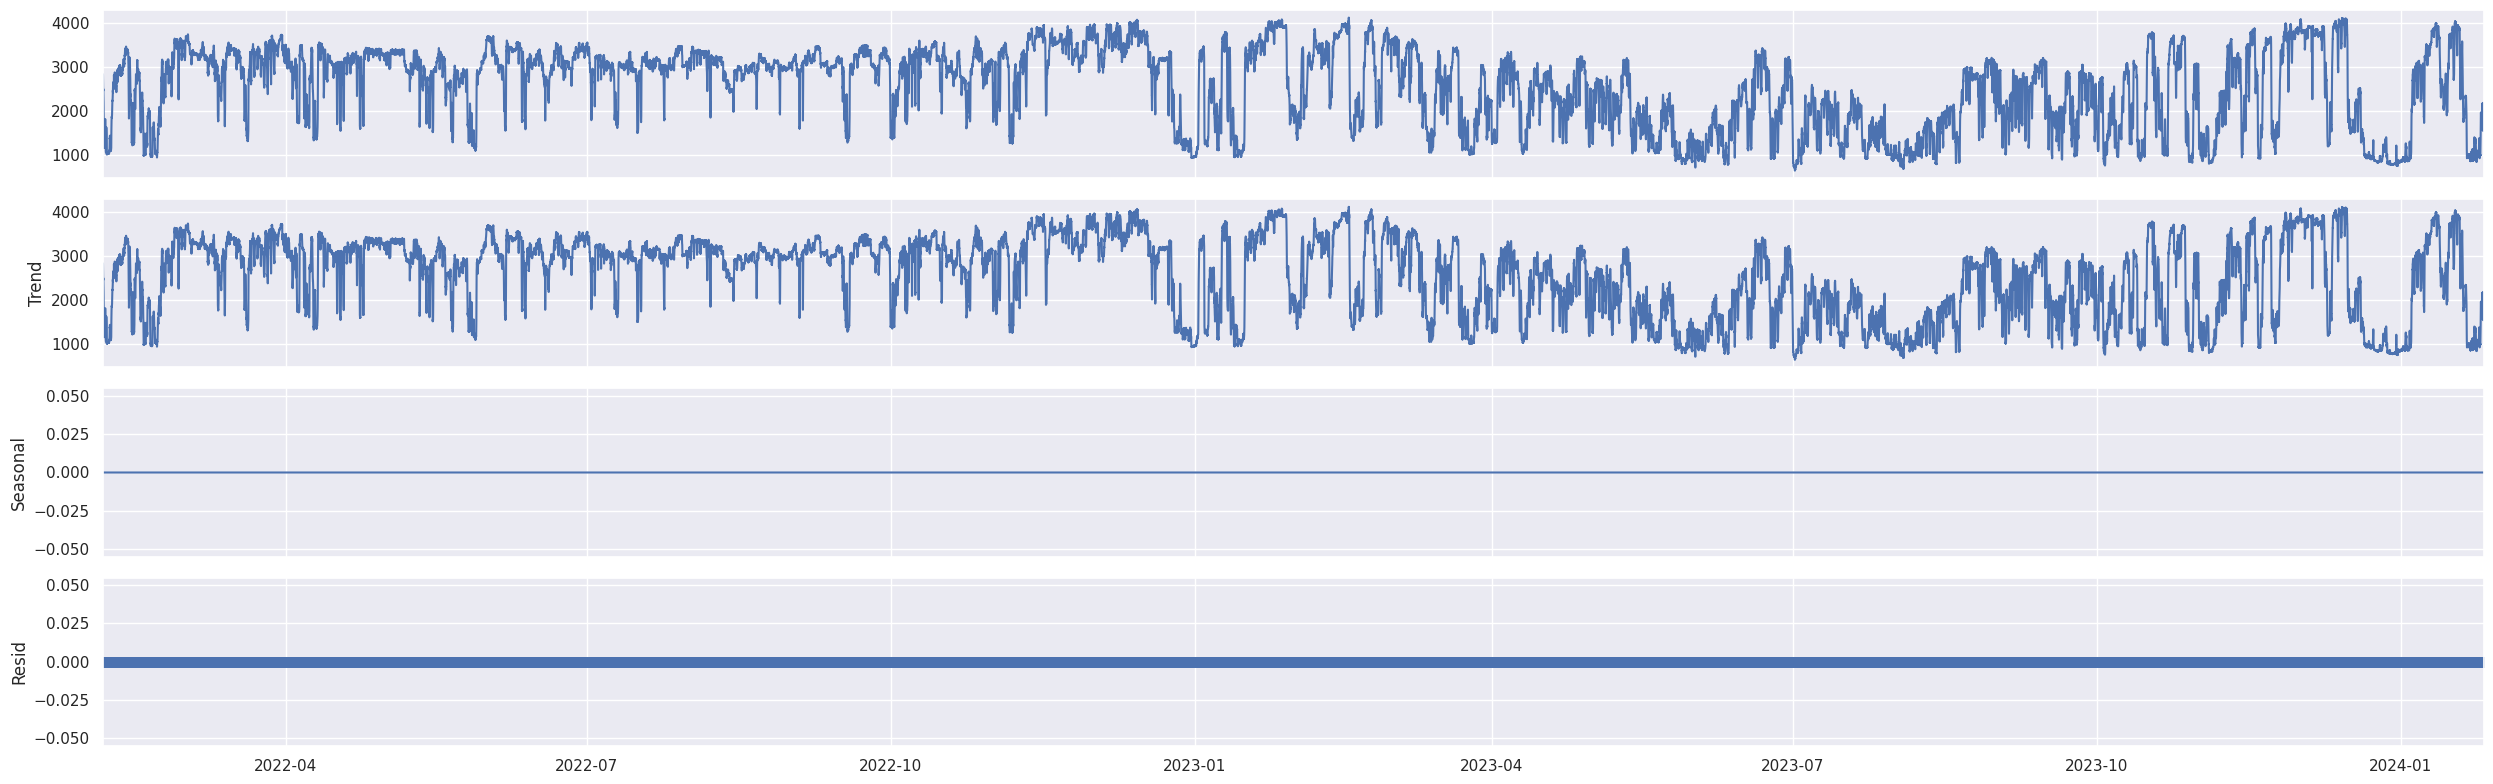

In [149]:
# Perform seasonal decomposition
result = seasonal_decompose(train_test_data, model='additive', extrapolate_trend='freq', period=1)

# Plot the decomposed components
result.plot()
plt.show()

In [150]:
is_stationary = f.adf_test(full_res=False)
print(is_stationary)

True


In [151]:
f.set_test_length(0.10)

In [152]:
f.eval_cis()

In [153]:
f.add_time_trend()

In [154]:
f.add_seasonal_regressors('month','quarter','week','dayofyear',raw=False,sincos=True)
f.add_seasonal_regressors('dayofweek','is_leap_year','week',raw=False,dummy=True,drop_first=True)
f.add_seasonal_regressors('year')

In [155]:
f.generate_future_dates(1344)
f.set_estimator('lstm')

Epoch 1/25
1555/1555 [==============================] - 27s 14ms/step - loss: 0.0583 - val_loss: 0.0726
Epoch 2/25
1555/1555 [==============================] - 20s 13ms/step - loss: 0.0543 - val_loss: 0.0542
Epoch 3/25
1555/1555 [==============================] - 19s 12ms/step - loss: 0.0507 - val_loss: 0.0558
Epoch 4/25
1555/1555 [==============================] - 19s 12ms/step - loss: 0.0498 - val_loss: 0.0552
Epoch 5/25
1555/1555 [==============================] - 21s 13ms/step - loss: 0.0494 - val_loss: 0.0541
Epoch 6/25
1555/1555 [==============================] - 21s 13ms/step - loss: 0.0493 - val_loss: 0.0570
Epoch 7/25
1555/1555 [==============================] - 20s 13ms/step - loss: 0.0495 - val_loss: 0.0545
Epoch 8/25
1555/1555 [==============================] - 20s 13ms/step - loss: 0.0491 - val_loss: 0.0548
Epoch 9/25
1555/1555 [==============================] - 20s 13ms/step - loss: 0.0487 - val_loss: 0.0559
Epoch 10/25
1555/1555 [==============================] - 19s 12m

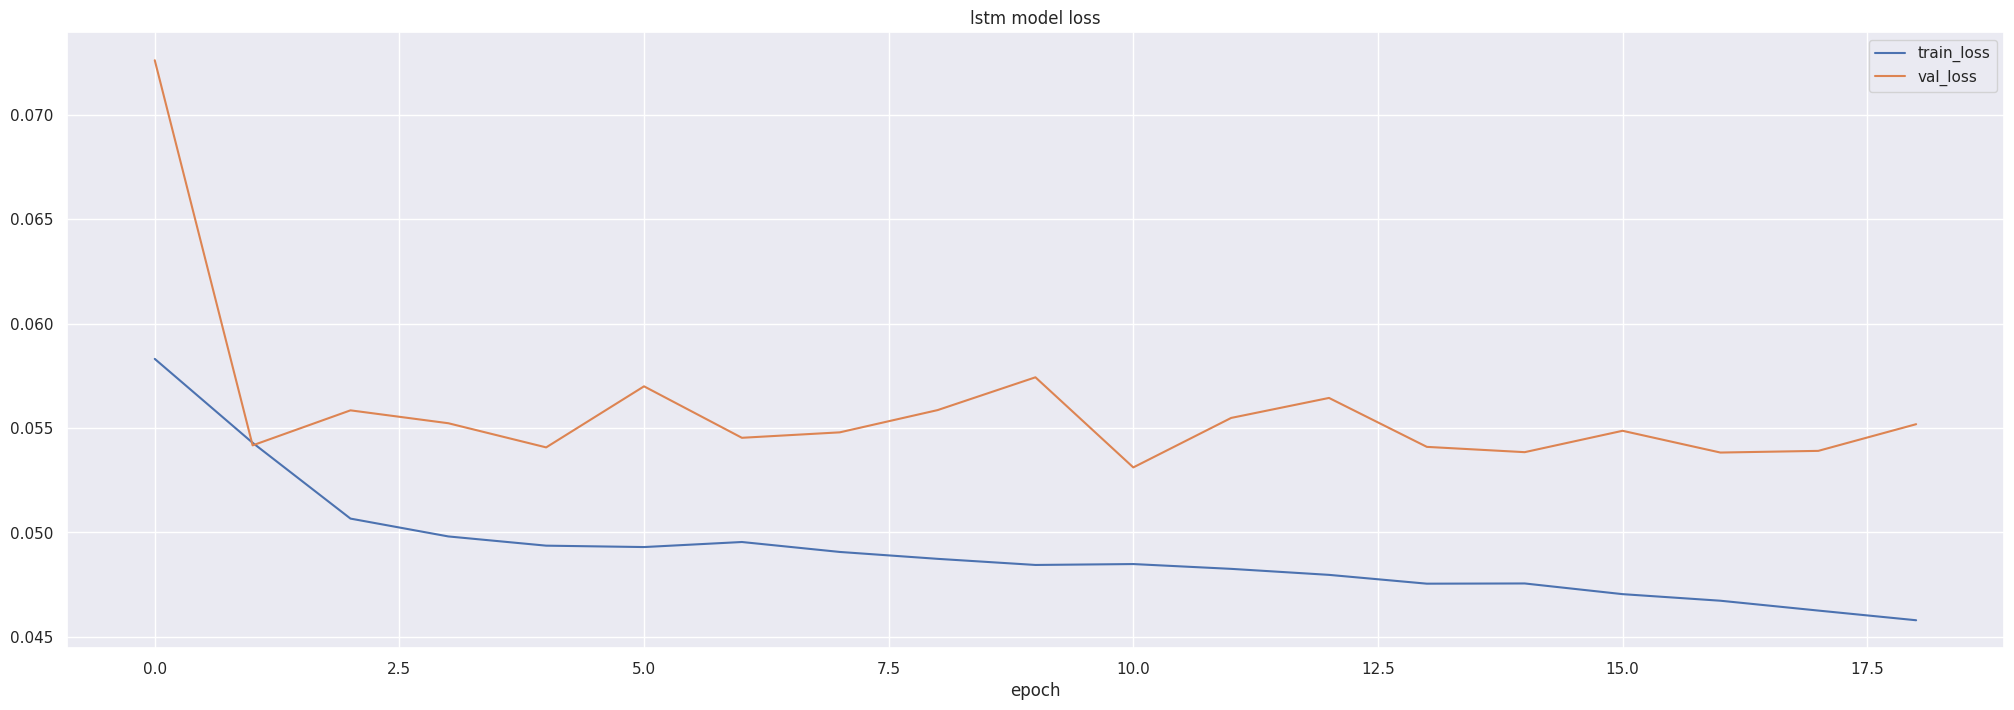

Epoch 1/25
1906/1906 [==============================] - 30s 13ms/step - loss: 0.0498 - val_loss: 0.1019
Epoch 2/25
1906/1906 [==============================] - 22s 12ms/step - loss: 0.0470 - val_loss: 0.1022
Epoch 3/25
1906/1906 [==============================] - 21s 11ms/step - loss: 0.0467 - val_loss: 0.1071
Epoch 4/25
1906/1906 [==============================] - 21s 11ms/step - loss: 0.0464 - val_loss: 0.1035
Epoch 5/25
1906/1906 [==============================] - 21s 11ms/step - loss: 0.0459 - val_loss: 0.1037
Epoch 6/25
1906/1906 [==============================] - 21s 11ms/step - loss: 0.0455 - val_loss: 0.1032
Epoch 7/25
1906/1906 [==============================] - 22s 11ms/step - loss: 0.0452 - val_loss: 0.1024
Epoch 8/25
1906/1906 [==============================] - 22s 11ms/step - loss: 0.0449 - val_loss: 0.1032
Epoch 9/25
2118/2118 [==============================] - 10s 5ms/step


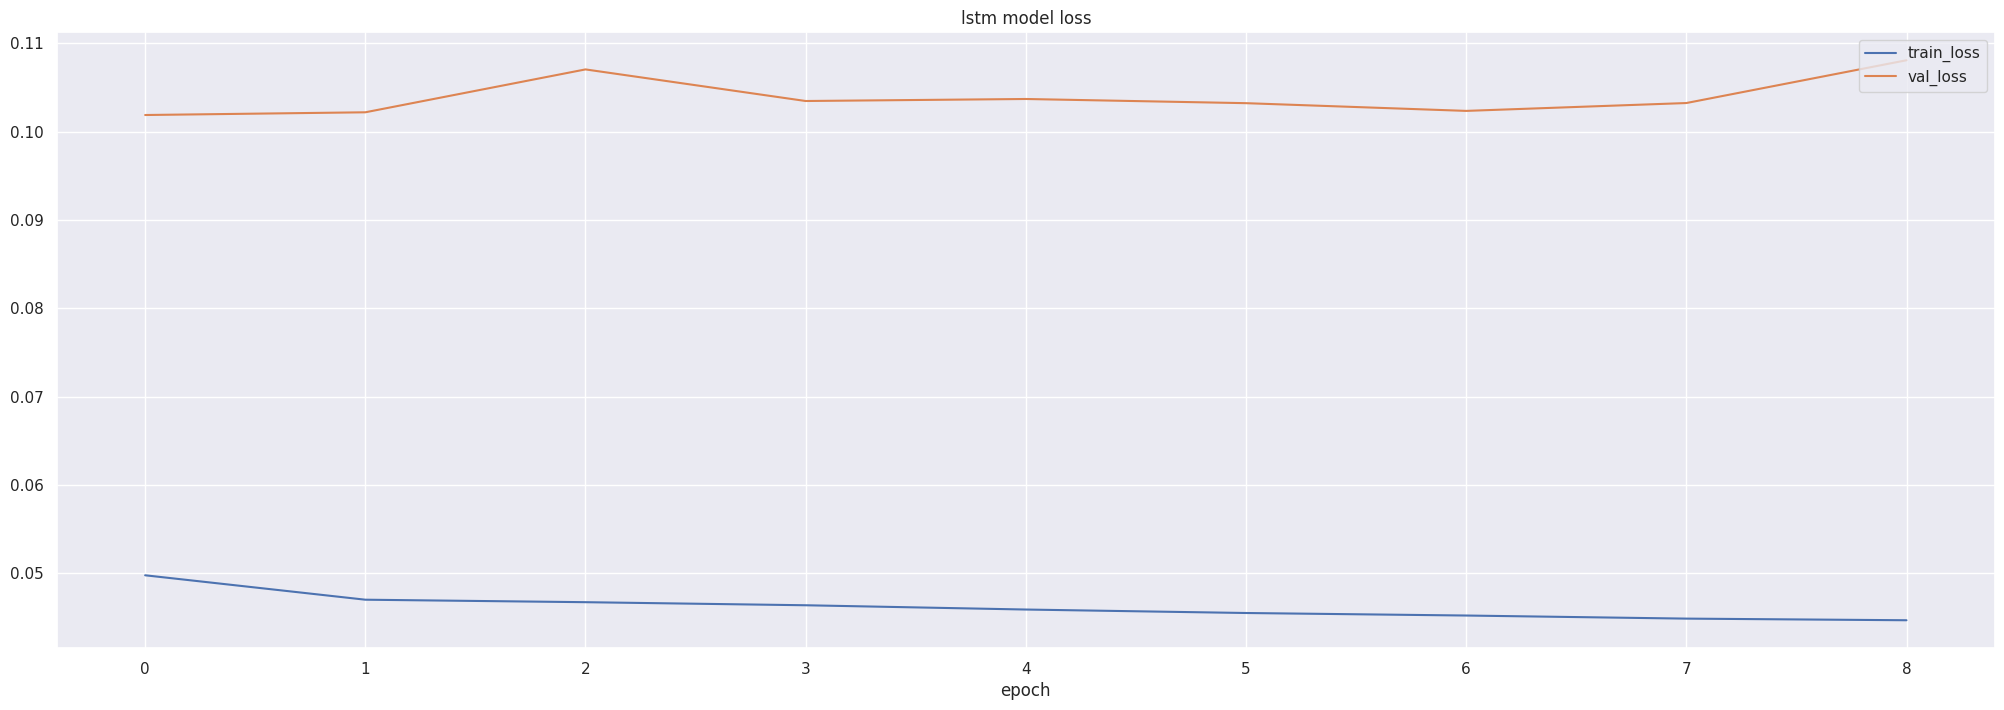

In [158]:
f.manual_forecast(call_me='lstm_best',
                  lags=36,
                  batch_size=32,
                  epochs=25,
                  validation_split=0.1,
                  activation='tanh',
                  optimizer='Adam',
                  learning_rate=0.001,
                  loss='mean_squared_error',
                  callbacks=EarlyStopping(monitor='val_loss',
                                          patience=8),
                  lstm_layer_sizes=(72,)*4,
                  dropout=(0,)*4,
                  plot_loss=True)

Number of NaN values in 'lstm_best' column: 0
No NaN values in the 'lstm_best' column.
output is non-zero
Mean Absolute Error (MAE) validation set vs prediction set : 456.3661564289624
Mean Absolute Percentage Error (MAPE) validation set vs prediction set : 32.17%
Root Mean Squared Error (RMSE) validation set vs prediction set : 551.0696608052432


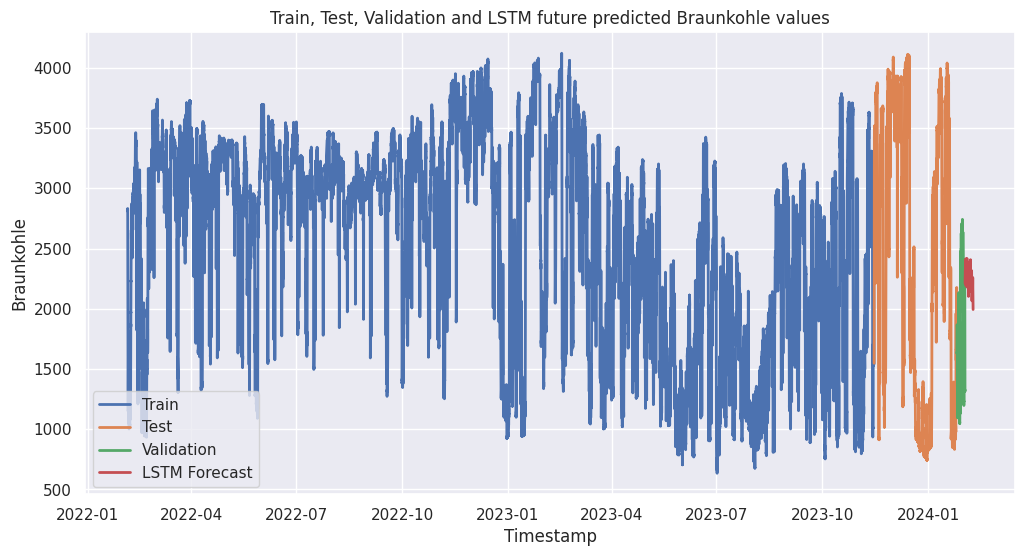

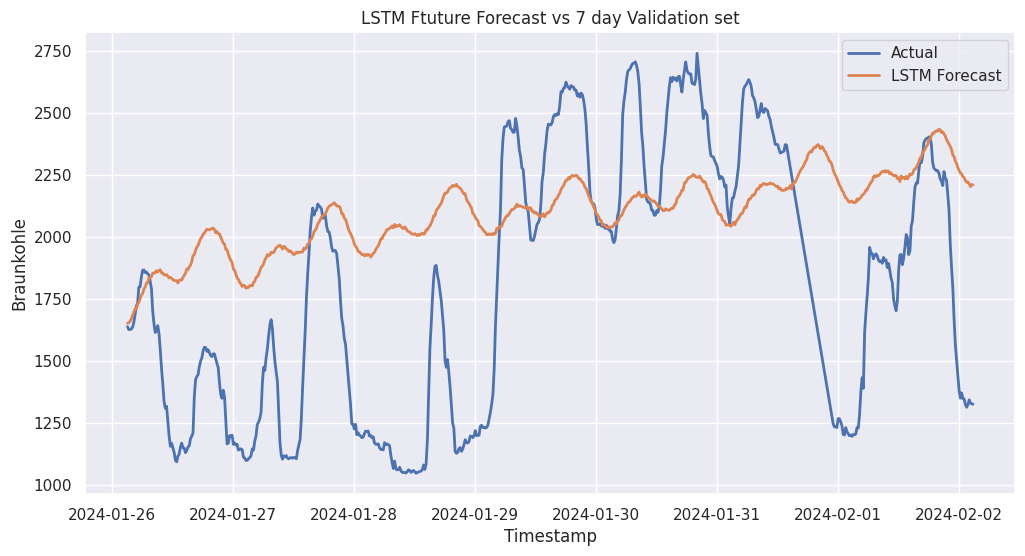

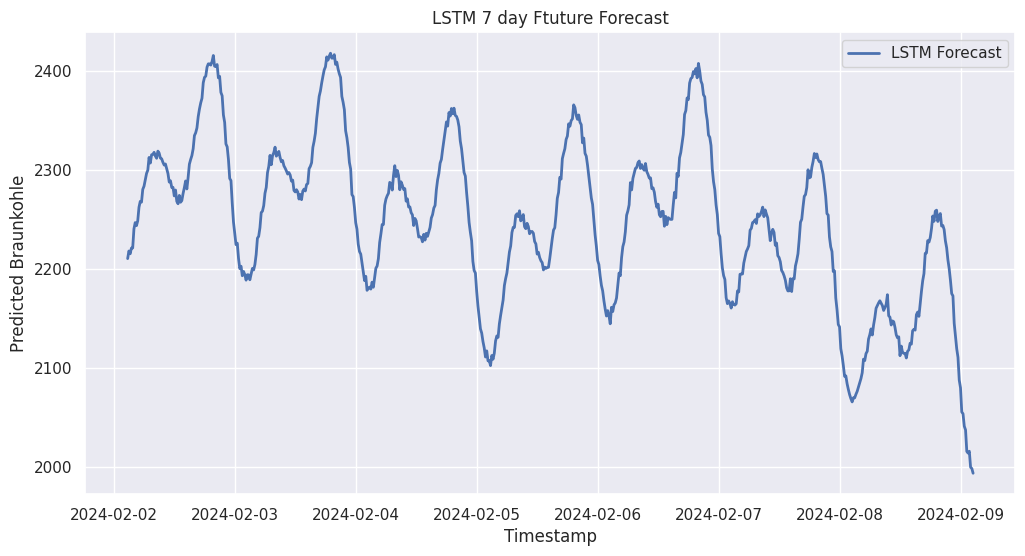

In [159]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

# Get fture forecast values and index
lstm_default_forecasted_df = f.export('lvl_fcsts')
last_timestamp = validation_data.index[-1]
new_index = pd.date_range(start=last_timestamp, periods=672, freq='15T')
existing_index_series = pd.Series(validation_data.index)
new_index_series = pd.Series(new_index)
concatenated_series = pd.concat([existing_index_series, new_index_series])
lstm_default_forecasted_df.index = concatenated_series


# Check for NaN in prediction
nan_count = lstm_default_forecasted_df["lstm_best"].isna().sum()
print("Number of NaN values in 'lstm_best' column:", nan_count)

if nan_count > 0:
    print("There are NaN values in the 'lstm_best' column.")
    # Optionally, print or handle the rows with NaN values
    print(lstm_default_forecasted_df[lstm_default_forecasted_df["lstm_best"].isna()])
else:
    print("No NaN values in the 'lstm_best' column.")

if (lstm_default_forecasted_df["lstm_best"] == 0).any():
  print("We have 0 values in lstm_best")
else:
  print("output is non-zero")


# Calculate Metrics
mae = mean_absolute_error(validation_data["Braunkohle"].values, lstm_default_forecasted_df["lstm_best"].values[:672])
mape = mean_absolute_percentage_error(validation_data["Braunkohle"].values, lstm_default_forecasted_df["lstm_best"].values[:672])
rmse = root_mean_squared_error(validation_data["Braunkohle"].values, lstm_default_forecasted_df["lstm_best"].values[:672])


# Print metrics
print(f'Mean Absolute Error (MAE) validation set vs prediction set : {mae}')
print(f'Mean Absolute Percentage Error (MAPE) validation set vs prediction set : {mape*100:.2f}%')
print(f'Root Mean Squared Error (RMSE) validation set vs prediction set : {rmse}')

# Split train_test_data into separate train and test sets and train_index and test_index
train_index, test_index = train_test_split(train_test_data.index, test_size=0.1, shuffle=False, random_state=42)
train,test = train_test_split(train_test_data["Braunkohle"], test_size=0.1, shuffle=False, random_state=42)


# Plotting train+test, validation and future predictions together
plt.figure(figsize=(12, 6))
plt.plot(train_index, train, label='Train', linewidth=2)
plt.plot(test_index, test, label='Test', linewidth=2)
plt.plot(validation_data.index, validation_data["Braunkohle"], label='Validation', linewidth=2)
plt.plot(lstm_default_forecasted_df.index[672:], lstm_default_forecasted_df["lstm_best"][672:], label='LSTM Forecast', linewidth=2)
plt.xlabel('Timestamp')
plt.ylabel('Braunkohle')
plt.title('Train, Test, Validation and LSTM future predicted Braunkohle values')
plt.legend()
plt.show()

# Plotting simulated future with validation
plt.figure(figsize=(12, 6))
plt.plot(validation_data.index, validation_data["Braunkohle"], label='Actual', linewidth=2)
plt.plot(validation_data.index, lstm_default_forecasted_df["lstm_best"][:672], label='LSTM Forecast', linewidth=2)
plt.xlabel('Timestamp')
plt.ylabel('Braunkohle')
plt.title('LSTM Ftuture Forecast vs 7 day Validation set')
plt.legend()
plt.show()

# Plotting real future
plt.figure(figsize=(12, 6))
plt.plot(lstm_default_forecasted_df.index[672:], lstm_default_forecasted_df["lstm_best"][672:], label='LSTM Forecast', linewidth=2)
plt.xlabel('Timestamp')
plt.ylabel('Predicted Braunkohle')
plt.title('LSTM 7 day Ftuture Forecast')
plt.legend()
plt.show()


In [160]:
last_672_rows = lstm_default_forecasted_df.tail(672)
result_df = pd.DataFrame({
    'Timestamp': last_672_rows.index,
    'Predicted_Braunkohle_Values': last_672_rows["lstm_best"].values
})

# Save the last 672 rows to a CSV file
last_672_rows.to_csv("Braunkohle_7_Days_Future_Forecast.csv", index=False)

In [161]:
first_672_rows = lstm_default_forecasted_df.tail(672)
result_df = pd.DataFrame({
    'Timestamp': validation_data.index,
    'Actual_Braunkohle_Values': validation_data["Braunkohle"].values,
    'Predicted_Braunkohle_Values': first_672_rows["lstm_best"].values
})

# Save the DataFrame to a CSV file
result_df.to_csv("Braunkohle_7_Days_Prediction_Validation_Data.csv", index=False)

In [162]:
validation_data.tail(160)

,Braunkohle
_time,
2024-01-31 11:00:00+00:00,2425.000
2024-01-31 11:15:00+00:00,2403.500
2024-01-31 11:30:00+00:00,2375.000
2024-01-31 11:45:00+00:00,2374.625
2024-01-31 12:00:00+00:00,2374.250
...,...
2024-02-02 01:45:00+00:00,1326.250
2024-02-02 02:00:00+00:00,1344.250
2024-02-02 02:15:00+00:00,1330.500
